### xAInet, a protein language model for sequence classification projected to describe aminoacidic importance via integratedgradients with captum

xAInet is a transformer based protein language model capables of classifying proteins (binary choice) from only relate aminoacidic sequence (canonical ones)

The model transforms the protein sequence input into corresponding tokens and then, to final embeddings (512 dimensions). 

Decoder module takes in embeddings anf generate features, then passed into a stack of linear layers in order to make the final class prediction.

Embeddings representations are optimize via backpropagation and via a contrastive loss function.

The model needs to be trained using a training dataet (csv file, first column: sequence, second column: label, 0 or 1).

Finally, the model is passed to captum library in order to integrate gradients and obtain aminoacidic importance (saliency between input and output).



In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# install captum for saliency computation

!pip install captum

In [1]:
# import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import os
import time
from sklearn.metrics import auc, roc_curve, average_precision_score, precision_recall_curve
from termcolor import colored
import pdb
import random
import pandas as pd
import csv
import captum

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def generate_data(file):
    # Amino acid dictionary
    aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23}
    
    # Open csv file 
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
      

    pep_codes = []
    labels = []
    peps = []
    
    for pep in lines:
        pep, label = pep.split(",")
        if len(pep) <= 299:  # Check if sequence length is less than or equal to 500
            peps.append(pep)
            labels.append(int(label))
            current_pep = []
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))

    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)

    return data, torch.tensor(labels)


In [3]:
data, label = generate_data("./test_loc_s.csv")

# Split 80/20 for train/test datasets creation
train_rows = int(0.8 * total_rows)
test_rows = total_rows - train_rows
   
train_data = data[:train_rows]
test_data = data[train_rows:]
    
train_label = label[:train_rows]
test_label = label[train_rows:]


train_dataset = Data.TensorDataset(train_data, train_label)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size = 64
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: './test_loc_s.csv'

In [ ]:
# lunghezza delle proteine x fase di inferenza

len(data[1])


299

In [3]:
class xAInet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.hidden_dim = 25
    self.batch_size = 32
    self.embedding_dim = 512

    self.embedding_layer = nn.Embedding(24, self.embedding_dim, padding_idx=0)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)

    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
    self.gru = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=2,
                      bidirectional=True, dropout=.2)
    
    self.block_seq = nn.Sequential(nn.Linear(15050, 2048),
                                   nn.BatchNorm1d(2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048, 1024),
                                   nn.BatchNorm1d(1024),
                                   nn.LeakyReLU(),
                                   nn.Linear(1024, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Linear(256, 8),
                                   nn.Linear(8, 2))
    
    
  def forward(self, seq):
        seq = seq.long()
        embeddings = self.embedding_layer(seq)
        output = self.transformer_encoder(embeddings).permute(1, 0, 2)
        output, hn = self.gru(output)
        output = output.permute(1, 0, 2)
        hn = hn.permute(1, 0, 2)
       
        output = output.reshape(output.shape[0], -1)
        hn = hn.reshape(output.shape[0], -1)
        
        output = torch.cat([output, hn], 1)
        output = self.block_seq(output)
        
       

        return output

  def train_model(self, seq):
    #with torch.no_grad():
        output = self.forward(seq)

        return output

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [ ]:
def collate(batch):
    seq1_ls = []
    seq2_ls = []
    label1_ls = []
    label2_ls = []
    label_ls = []


    batch_size = len(batch)
    for i in range(int(batch_size / 2)):
        seq1, label1= batch[i][0], batch[i][1]
        seq2, label2= batch[i + int(batch_size / 2)][0], \
                                       batch[i + int(batch_size / 2)][1], \
                                       
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label = (label1 ^ label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))

        

    seq1 = torch.cat(seq1_ls).to(device)
    seq2 = torch.cat(seq2_ls).to(device)

    

    label = torch.cat(label_ls).to(device)
    label1 = torch.cat(label1_ls).to(device)
    label2 = torch.cat(label2_ls).to(device)
    return seq1, seq2, label, label1, label2


train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              shuffle=True, collate_fn=collate)

device = torch.device("cpu", 0)


def evaluate(data_iter, net):
    pred_prob = []
    label_pred = []
    label_real = []
    for x, y in data_iter:
        x, y = x.to(device), y.to(device)
        outputs = net.train_model(x)
        outputs_cpu = outputs.cpu()
        y_cpu = y.cpu()
        pred_prob_positive = outputs_cpu[:, 1]
        pred_prob = pred_prob + pred_prob_positive.tolist()
        label_pred = label_pred + outputs.argmax(dim=1).tolist()
        label_real = label_real + y_cpu.tolist()
    performance, roc_data, prc_data = caculate_metric(pred_prob, label_pred, label_real)
    return performance, roc_data, prc_data


def caculate_metric(pred_prob, label_pred, label_real):
    test_num = len(label_real)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for index in range(test_num):
        if label_real[index] == 1:
            if label_real[index] == label_pred[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if label_real[index] == label_pred[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    # Accuracy
    ACC = float(tp + tn) / test_num

    # Sensitivity
    if tp + fn == 0:
        Recall = Sensitivity = 0
    else:
        Recall = Sensitivity = float(tp) / (tp + fn)

    # Specificity
    if tn + fp == 0:
        Specificity = 0
    else:
        Specificity = float(tn) / (tn + fp)

    # MCC
    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        MCC = 0
    else:
        MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

    # ROC and AUC
    FPR, TPR, thresholds = roc_curve(label_real, pred_prob, pos_label=1)

    AUC = auc(FPR, TPR)

    # PRC and AP
    precision, recall, thresholds = precision_recall_curve(label_real, pred_prob, pos_label=1)
    AP = average_precision_score(label_real, pred_prob, average='macro', pos_label=1, sample_weight=None)

    performance = [ACC, Sensitivity, Specificity, AUC, MCC]
    roc_data = [FPR, TPR, AUC]
    prc_data = [recall, precision, AP]
    return performance, roc_data, prc_data


def to_log(log):
    with open("./results/ExamPle_Log.log", "a+") as f:
        f.write(log + '\n')

In [ ]:
net = xAInet().to(device)
lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = ContrastiveLoss()
criterion_model = nn.CrossEntropyLoss(reduction='sum')
best_acc = 0
EPOCH = 20
for epoch in range(EPOCH):
    loss_ls = []
    loss1_ls = []
    loss2_3_ls = []
    t0 = time.time()
    net.train()
    for seq1, seq2, label, label1, label2 in train_iter_cont:
        output1 = net(seq1)
        output2 = net(seq2)
         
        #pdb.set_trace()
        output3 = net.train_model(seq1)

        output4 = net.train_model(seq2)
        loss1 = criterion(output1, output2, label)
        loss2 = criterion_model(output3, label1)
        loss3 = criterion_model(output4, label2)
        loss = loss1 + loss2 + loss3
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ls.append(loss.item())
        loss1_ls.append(loss1.item())
        loss2_3_ls.append((loss2 + loss3).item())

    net.eval()
    with torch.no_grad():
        train_performance, train_roc_data, train_prc_data = evaluate(train_iter, net)
        test_performance, test_roc_data, test_prc_data = evaluate(test_iter, net)

    results = f"\nepoch: {epoch + 1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
    results += f'train_acc: {train_performance[0]:.4f}, time: {time.time() - t0:.2f}'
    results += '\n' + '=' * 16 + ' Test Performance. Epoch[{}] '.format(epoch + 1) + '=' * 16 \
               + '\n[ACC,\tSE,\t\tSP,\t\tAUC,\tMCC]\n' + '{:.4f},\t{:.4f},\t{:.4f},\t{:.4f},\t{:.4f}'.format(
        test_performance[0], test_performance[1], test_performance[2], test_performance[3],
        test_performance[4]) + '\n' + '=' * 60
    print(results)
    # to_log(results)
    test_acc = test_performance[0]  # test_performance: [ACC, Sensitivity, Specificity, AUC, MCC]
    if test_acc > best_acc:
        best_acc = test_acc
        best_performance = test_performance
        filename = '{}, {}[{:.3f}].pt'.format('ExamPle' + ', epoch[{}]'.format(epoch + 1), 'ACC', best_acc)
        save_path_pt = os.path.join('./Model', filename)
        # torch.save(net.state_dict(), save_path_pt, _use_new_zipfile_serialization=False)
        best_results = '\n' + '=' * 16 + colored(' Best Performance. Epoch[{}] ', 'red').format(epoch + 1) + '=' * 16 \
                       + '\n[ACC,\tSE,\t\tSP,\t\tAUC,\tMCC]\n' + '{:.4f},\t{:.4f},\t{:.4f},\t{:.4f},\t{:.4f}'.format(
            best_performance[0], best_performance[1], best_performance[2], best_performance[3],
            best_performance[4]) + '\n' + '=' * 60
        print(best_results)
        best_ROC = test_roc_data
        best_PRC = test_prc_data


epoch: 1, loss: 38.03354, loss1: 1.24773, loss2_3: 36.78582
train_acc: 0.9030, time: 338.87
================ Test Performance. Epoch[1] ================
[ACC,	SE,		SP,		AUC,	MCC]
0.7712,	0.7945,	0.7333,	0.8432,	0.5219

================ Best Performance. Epoch[1] ================
[ACC,	SE,		SP,		AUC,	MCC]
0.7712,	0.7945,	0.7333,	0.8432,	0.5219


In [ ]:
torch.save(net, './model.pt')

- Load model

In [4]:
model = torch.load('model_SSP.pt', map_location=torch.device('cpu'))

In [5]:
'''
def generate_data(file):
    # Amino acid dictionary
    aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23}
    
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()

    pep_codes = []
    labels = []
    peps = []
    
    for pep in lines:
        pep, label = pep.split(",")
        peps.append(pep)
        labels.append(int(label))
        current_pep = []
        for aa in pep:
            current_pep.append(aa_dict[aa])
        pep_codes.append(torch.tensor(current_pep))

        
    desired_length = 299
    padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in pep_codes]
# Apply pad_sequence on the padded_sequences
    #data = pad_sequence(padded_sequences, batch_first=True)
    
    data = rnn_utils.pad_sequence(padded_sequences, batch_first=True)  # Fill the sequence to the same length
  

    return data
'''

'\ndef generate_data(file):\n    # Amino acid dictionary\n    aa_dict = {\'A\': 1, \'R\': 2, \'N\': 3, \'D\': 4, \'C\': 5, \'Q\': 6, \'E\': 7, \'G\': 8, \'H\': 9, \'I\': 10,\n               \'L\': 11, \'K\': 12, \'M\': 13, \'F\': 14, \'P\': 15, \'O\': 16, \'S\': 17, \'U\': 18, \'T\': 19,\n               \'W\': 20, \'Y\': 21, \'V\': 22, \'X\': 23}\n    \n    with open(file, \'r\') as inf:\n        lines = inf.read().splitlines()\n\n    pep_codes = []\n    labels = []\n    peps = []\n    \n    for pep in lines:\n        pep, label = pep.split(",")\n        peps.append(pep)\n        labels.append(int(label))\n        current_pep = []\n        for aa in pep:\n            current_pep.append(aa_dict[aa])\n        pep_codes.append(torch.tensor(current_pep))\n\n        \n    desired_length = 299\n    padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in pep_codes]\n# Apply pad_sequence on the padded_seque

In [ ]:
#data = generate_data('SSP_dataset.csv')

In [ ]:
#data = data.to('cpu')
#model = model.to('cpu')

xAI

In [36]:
device = 'cpu'

In [37]:
def model_output(inputs):

    #inputs = inputs[0].unsqueeze(0)
  
    out = model(inputs)
    # Apply softmax to convert prediction scores to probabilities
    probabilities = torch.softmax(out, dim=1)
    

    # Get the predicted classes by selecting the class with the highest probability
    predicted_classes = torch.argmax(probabilities, dim=1)  
    return predicted_classes


In [38]:
def construct_input_and_baseline(text):

    max_length = 512
    #baseline_token_id = rnn_utils.pad_sequence()
    

    input_ids = []
    token_list = []
    
    aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23, 'PAD': 0}
    
    for char in text:
      if char in aa_dict:
        input_ids.append(aa_dict[char])
        token_list.append(char)

    baseline_token_id = 13  # Corrisponde a 'M' nel dizionario aa_dict
    baseline_input_ids = [baseline_token_id] + [aa_dict['X']] * (len(input_ids) - 1)

    #baseline_token_id = 23
    #baseline_input_ids = [baseline_token_id] * len(input_ids)

    input_ids_tensor = torch.tensor([input_ids], device=device)
    baseline_input_ids_tensor = torch.tensor([baseline_input_ids], device=device)

    return input_ids_tensor, baseline_input_ids_tensor, token_list

In [39]:
df = pd.read_csv('SSP_dataset.csv', header=0 )
new_columns = ['seq', 'label']
df = df.set_axis(new_columns, axis=1)
df

,seq,label
0,MASYARKFLAIFLFLTIAVFFFSTLEVQAKVCLRYSKYFQGKCFDP...,1
1,MDEKWNLSKKEGSGSSYHHSSTNAKSSFLRSGSTSKSPLLRCSSQK...,0
2,MAQILIFIYALIIVLSLRLVVSSKTTLPCVSKDDCPLGLPPLSVTC...,1
3,MEVLSLNKNMLLKMIMMAMMWSMAKSVRHDVGGDDHGWNTNINMTK...,1
4,MSYPHQKQPSVAGYPPQPAATAYPAGPYVAPPPVGYPMKHGHDYPQ...,0
...,...,...
2362,MKGRRDKKHPPNVENNYKQCREKEYGGHLMDEEREKRRPEFYSGDG...,0
2363,MLMSWINSFLFGCKERCTHISLIIYFRWYFTFYKEYVNNSICQKFS...,0
2364,MEEENTLEETVYNWDYTSAFAAVLLLLIATAVVRCICCTTDLRFCC...,1
2365,MYAPPEYQQASYVDHVRHHVQQRHEEKGCLYACLFALCCFCVFFCL...,0


In [40]:
test = []
for _, row in df.iterrows():
    if row['label'] == 1:
        test.append(row['seq'])

print(test)

['MASYARKFLAIFLFLTIAVFFFSTLEVQAKVCLRYSKYFQGKCFDPAGCKNNCTQMEKAISGDCHPDHGFGSACLCLFNC', 'MAQILIFIYALIIVLSLRLVVSSKTTLPCVSKDDCPLGLPPLSVTCIKKICLYYVEGF', 'MEVLSLNKNMLLKMIMMAMMWSMAKSVRHDVGGDDHGWNTNINMTKWSSDKHFHLNEWLFFGYDRHFFSVLEVNKTSYENCIDSGFIKNITTGVGREVFQLSEAKTHYFISGGGFCQRGVKVAIDVNEHVAPAPQPTPHKSSATSNIQIYHSLAVLILIFMCTNFLV', 'MGLRGVGSIFILFLNLIFVSTLVFAKPAPKRPPPPPLQVTCPSLPPPVHAPSTPPSTPPIMVSPSTQPPVVDPFTPPPSTPPSTPPTMVAPATPPPMVAPSTTPTSTPPSTPPTIVAPSTPPPMVDPSTLPCTPSFMVAPLAPPPVAEPLTPPPSTPATMVAPATQPPMDDPATQLPLK', 'MTSLEVIVMFLWTCAHSETNRNVQNKFGKSRETVSRKFGEVLESLCLLAKEIVRPPDFNLAETPSKIKNDRRYWPHFEGCIGAIDRTHLPAIVPTKDQIRYIGRKGFPTQNVMLVCNLDMLFNFVVVGWPSTAHDTRILSLRHVIVFVKNISFIF', 'MAGHCWIFLLWFVCASAAGFSAMVLVSNWCCCLLVRCVLLQQLRAVAAASVLASSVVSLPPRLARLVWGLC', 'MSNLSGNNVFVMLFSLCLLLLLLLNIVVGSPPSSASGVEDYQNLFGLSSREEVVEIAGYGEEKLSTVLITGSLHCDGPNNNHHSNAWPIPGALVSVNCQSHATERTGKAMVANGVTDEFGDFMVDLPSYLHAIPNLEKICRVKVHKIPKGSLCRPARHVNKQKGLLKLSTIGNGIRTYDAGTIRIQHSASELVRASPRKDIGEIKE', 'MERSVNYYILLLLLAHFLCSGYSETNKEAHGHVTQVNPQSHKEKLLEFKAPIST

In [41]:
text = 'MASYARKFLAIFLFLTIAVFFFSTLEVQAKVCLRYSKYFQGKCFDPAGCKNNCTQMEKAISGDCHPDHGFGSACLCLFNC'

input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

print(f'original text: {input_ids}')
print(f'baseline text: {baseline_input_ids}')
print(f'all tokens: {all_tokens}')


original text: tensor([[13,  1, 17, 21,  1,  2, 12, 14, 11,  1, 10, 14, 11, 14, 11, 19, 10,  1,
         22, 14, 14, 14, 17, 19, 11,  7, 22,  6,  1, 12, 22,  5, 11,  2, 21, 17,
         12, 21, 14,  6,  8, 12,  5, 14,  4, 15,  1,  8,  5, 12,  3,  3,  5, 19,
          6, 13,  7, 12,  1, 10, 17,  8,  4,  5,  9, 15,  4,  9,  8, 14,  8, 17,
          1,  5, 11,  5, 11, 14,  3,  5]])
baseline text: tensor([[13, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23]])
all tokens: ['M', 'A', 'S', 'Y', 'A', 'R', 'K', 'F', 'L', 'A', 'I', 'F', 'L', 'F', 'L', 'T', 'I', 'A', 'V', 'F', 'F', 'F', 'S', 'T', 'L', 'E', 'V', 'Q', 'A', 'K', 'V', 'C', 'L', 'R', 'Y', 'S', 'K', 'Y', 'F', 'Q', 'G', 'K', 'C', 'F', 'D'

In [42]:
desired_length = 299
padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in input_ids]
# Apply pad_sequence on the padded_sequences
    #data = pad_sequence(padded_sequences, batch_first=True)
    
input_ids = rnn_utils.pad_sequence(padded_sequences, batch_first=True)

In [43]:
desired_length = 299
padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in baseline_input_ids]
# Apply pad_sequence on the padded_sequences
    #data = pad_sequence(padded_sequences, batch_first=True)
    
baseline_input_ids = rnn_utils.pad_sequence(padded_sequences, batch_first=True)

In [44]:
print(f'original text: {input_ids}')
print(f'baseline text: {baseline_input_ids}')
print(f'all tokens: {all_tokens}')


original text: tensor([[13.,  1., 17., 21.,  1.,  2., 12., 14., 11.,  1., 10., 14., 11., 14.,
         11., 19., 10.,  1., 22., 14., 14., 14., 17., 19., 11.,  7., 22.,  6.,
          1., 12., 22.,  5., 11.,  2., 21., 17., 12., 21., 14.,  6.,  8., 12.,
          5., 14.,  4., 15.,  1.,  8.,  5., 12.,  3.,  3.,  5., 19.,  6., 13.,
          7., 12.,  1., 10., 17.,  8.,  4.,  5.,  9., 15.,  4.,  9.,  8., 14.,
          8., 17.,  1.,  5., 11.,  5., 11., 14.,  3.,  5.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.

In [45]:
from captum.attr import LayerIntegratedGradients

lig = LayerIntegratedGradients(model, model.embedding_layer)

In [46]:
attributions, delta = lig.attribute(inputs= input_ids,
                                    baselines= baseline_input_ids,
                                    target = model_output(input_ids),
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    n_steps = 1000,
                                    method = 'gausslegendre'
                                    )

In [47]:
def summarize_attributions(attributions):

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

attributions_sum = summarize_attributions(attributions)

print(attributions.size())
print(attributions_sum.size())


torch.Size([1, 299, 512])
torch.Size([299])


In [48]:
attributions_list = attributions_sum.tolist()

In [49]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23, 'PAD': 0}

In [50]:
def generate_text_from_tokens(input_ids, aa_dict):
    text = []
    for token in input_ids:
        if token.item() in aa_dict.values():
            aminoacido = list(aa_dict.keys())[list(aa_dict.values()).index(token.item())]
            text.append(aminoacido)
    return text

In [51]:
generated_text = generate_text_from_tokens(input_ids[0], aa_dict)
print(generated_text)

['M', 'A', 'S', 'Y', 'A', 'R', 'K', 'F', 'L', 'A', 'I', 'F', 'L', 'F', 'L', 'T', 'I', 'A', 'V', 'F', 'F', 'F', 'S', 'T', 'L', 'E', 'V', 'Q', 'A', 'K', 'V', 'C', 'L', 'R', 'Y', 'S', 'K', 'Y', 'F', 'Q', 'G', 'K', 'C', 'F', 'D', 'P', 'A', 'G', 'C', 'K', 'N', 'N', 'C', 'T', 'Q', 'M', 'E', 'K', 'A', 'I', 'S', 'G', 'D', 'C', 'H', 'P', 'D', 'H', 'G', 'F', 'G', 'S', 'A', 'C', 'L', 'C', 'L', 'F', 'N', 'C', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD

In [52]:
attributions_sum = attributions_sum.tolist()

In [58]:
attributions_sum

[0.0,
 0.12299069091863529,
 0.08296964070723153,
 -0.06133882264341699,
 0.17636308818935081,
 -0.14697826923440765,
 -0.07133127188651305,
 0.2638104645187104,
 0.30965949242362417,
 0.07902418363446742,
 0.26913284466330994,
 0.16263260530355234,
 0.30339172045286317,
 0.21447522242542288,
 0.2852307991359013,
 0.0995403395752341,
 0.29744770557674993,
 0.027275780526341664,
 0.24463427564945048,
 0.08834724460039602,
 0.05176251262042038,
 0.02818812038672728,
 -0.15573025524282014,
 0.07551211606256776,
 0.04761818486782937,
 -0.01587878836637196,
 0.00699106648016187,
 -0.11856410431534367,
 -0.03929418996587047,
 -0.1463473929311392,
 -0.007793518022249592,
 -0.018035430936644628,
 0.16033880788651422,
 -0.01975346457676904,
 -0.0443712178035049,
 -0.1123465642214993,
 -0.13154212231478712,
 0.010505501553027742,
 0.04065802938545872,
 0.010254030467631388,
 -0.01895755623573856,
 -0.017348402389239813,
 -0.016503552632187383,
 0.02747910097906948,
 0.061380127269436,
 -0.135630

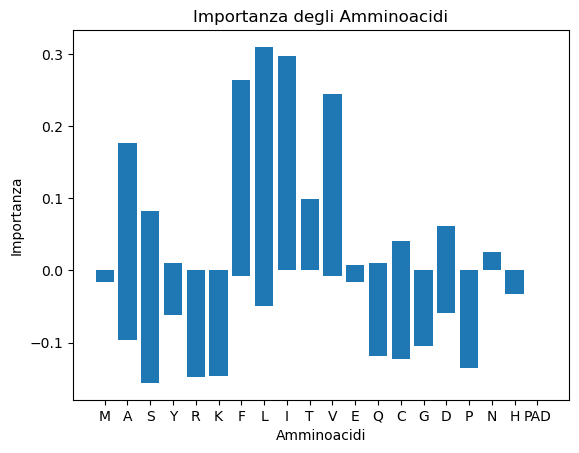

In [53]:
import matplotlib.pyplot as plt                #non tiene conto della posizione relativa, fa una somma dell'importanza sugli amminoacidi uguali

# Etichette degli amminoacidi


# Creazione del grafico a barre
plt.bar(generated_text, attributions_sum)
plt.xlabel('Amminoacidi')
plt.ylabel('Importanza')
plt.title('Importanza degli Amminoacidi')
plt.show()


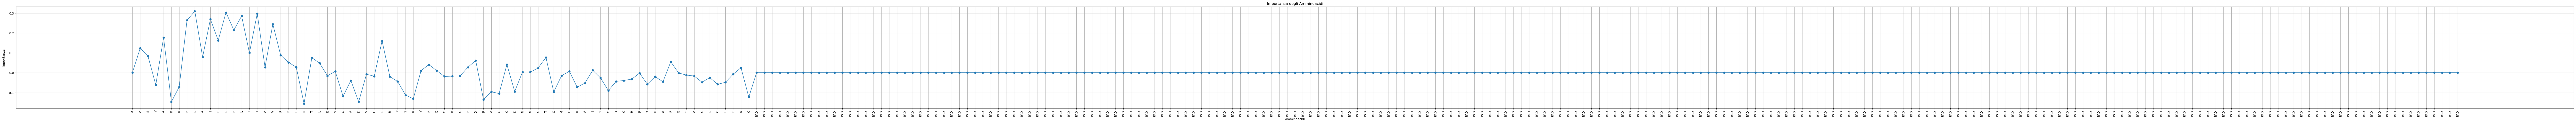

In [54]:
x = range(len(generated_text))

fig = plt.figure(figsize=(len(generated_text) / 2, 6))
plt.grid(True)


plt.plot(x, attributions_sum, marker='o')

plt.xticks(x, generated_text)
plt.xticks(rotation=90)

plt.xlabel('Amminoacidi')
plt.ylabel('Importanza')
plt.title('Importanza degli Amminoacidi')
plt.show()

In [ ]:
'''
from termcolor import colored    #non funziona su colab, vedi dopo

# Rappresentazione testuale del testo generato con colori
for i in range(len(generated_text)):
    aminoacid = generated_text[i]
    score = attributions_sum[i]
    if score > 0:
        colored_aminoacid = colored(aminoacid, 'green')
    else:
        colored_aminoacid = colored(aminoacid, 'red')
    print(colored_aminoacid, end=' ')
'''

In [55]:
from IPython.display import Markdown, display

# Rappresentazione testuale del testo generato con colori
formatted_text = ""
for i in range(len(generated_text)):
    aminoacid = generated_text[i]
    score = attributions_sum[i]
    if score > 0:
        if score > 0.5:
            colored_aminoacid = f'<font color="darkgreen">{aminoacid}</font>'
        else:
            colored_aminoacid = f'<font color="green">{aminoacid}</font>'
    elif score < 0:
        colored_aminoacid = f'<font color="red">{aminoacid}</font>'
    else:
        colored_aminoacid = aminoacid
    formatted_text += colored_aminoacid + " "

display(Markdown(formatted_text))


M <font color="green">A</font> <font color="green">S</font> <font color="red">Y</font> <font color="green">A</font> <font color="red">R</font> <font color="red">K</font> <font color="green">F</font> <font color="green">L</font> <font color="green">A</font> <font color="green">I</font> <font color="green">F</font> <font color="green">L</font> <font color="green">F</font> <font color="green">L</font> <font color="green">T</font> <font color="green">I</font> <font color="green">A</font> <font color="green">V</font> <font color="green">F</font> <font color="green">F</font> <font color="green">F</font> <font color="red">S</font> <font color="green">T</font> <font color="green">L</font> <font color="red">E</font> <font color="green">V</font> <font color="red">Q</font> <font color="red">A</font> <font color="red">K</font> <font color="red">V</font> <font color="red">C</font> <font color="green">L</font> <font color="red">R</font> <font color="red">Y</font> <font color="red">S</font> <font color="red">K</font> <font color="green">Y</font> <font color="green">F</font> <font color="green">Q</font> <font color="red">G</font> <font color="red">K</font> <font color="red">C</font> <font color="green">F</font> <font color="green">D</font> <font color="red">P</font> <font color="red">A</font> <font color="red">G</font> <font color="green">C</font> <font color="red">K</font> <font color="green">N</font> <font color="green">N</font> <font color="green">C</font> <font color="green">T</font> <font color="red">Q</font> <font color="red">M</font> <font color="green">E</font> <font color="red">K</font> <font color="red">A</font> <font color="green">I</font> <font color="red">S</font> <font color="red">G</font> <font color="red">D</font> <font color="red">C</font> <font color="red">H</font> <font color="red">P</font> <font color="red">D</font> <font color="red">H</font> <font color="red">G</font> <font color="green">F</font> <font color="red">G</font> <font color="red">S</font> <font color="red">A</font> <font color="red">C</font> <font color="red">L</font> <font color="red">C</font> <font color="red">L</font> <font color="red">F</font> <font color="green">N</font> <font color="red">C</font> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 

In [57]:
from IPython.display import Markdown, display, HTML


# Rappresentazione testuale del testo generato con colori e box
formatted_text = ""
for i in range(len(generated_text)):
    aminoacid = generated_text[i]
    score = attributions_sum[i]
    
    # Calcolo dei valori RGB per gradazioni di colore
    if score > 0:
        r = 0
        g = int(score * 255)
        b = 0
    elif score < 0:
        r = int(abs(score) * 255)
        g = 0
        b = 0
    else:
        r = 0
        g = 0
        b = 0
    
    # Creazione del box con colore e testo
    colored_box = f'<div style="display: inline-block; padding: 3px; background-color: rgb({r},{g},{b});">{aminoacid}</div>'
    
    formatted_text += colored_box

display(HTML(formatted_text))


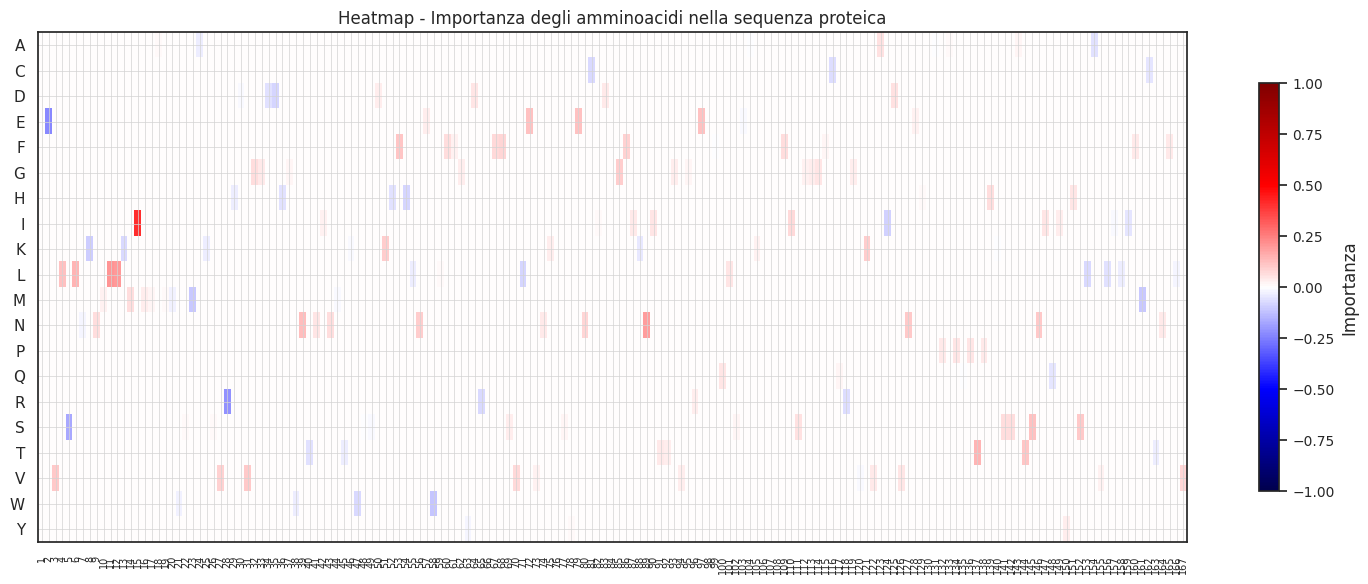

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors



# Rimozione degli elementi 'PAD' dalla sequenza e dagli attributi
generated_text = [aa for aa in generated_text if aa != 'PAD']
attributions_sum = [score for score, aa in zip(attributions_sum, generated_text) if aa != 'PAD']

# Creazione della lista di amminoacidi unici
unique_aminoacids = list(set(generated_text))
unique_aminoacids.sort()

# Creazione della matrice di attributi
attributions_matrix = np.zeros((len(unique_aminoacids), len(generated_text)))
for i, aminoacid in enumerate(generated_text):
    j = unique_aminoacids.index(aminoacid)
    attributions_matrix[j, i] = attributions_sum[i]

# Creazione della figura
fig, ax = plt.subplots(figsize=(15, 6))
 
# Tracciamento della heatmap
im = ax.imshow(attributions_matrix, cmap='seismic', aspect='auto', vmin=-1, vmax=1)



# Etichettatura degli amminoacidi sull'asse y
ax.set_yticks(np.arange(len(unique_aminoacids)))
ax.set_yticklabels(unique_aminoacids)

# Etichettatura delle posizioni sull'asse x
x_ticks = np.arange(0, len(generated_text), 1)
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.arange(1, len(generated_text)+1)[x_ticks], rotation=90)
ax.tick_params(axis='x', labelsize=7)

# Aggiunta di una barra dei colori
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)

# Personalizzazione della barra dei colori
cbar.set_label('Importanza')
cbar.ax.tick_params(labelsize=10)

# Titolo del grafico
ax.set_title('Heatmap - Importanza degli amminoacidi nella sequenza proteica')

ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)


# Ridimensionamento dei tick sull'asse y
plt.tight_layout()

# Visualizzazione del grafico
plt.show()


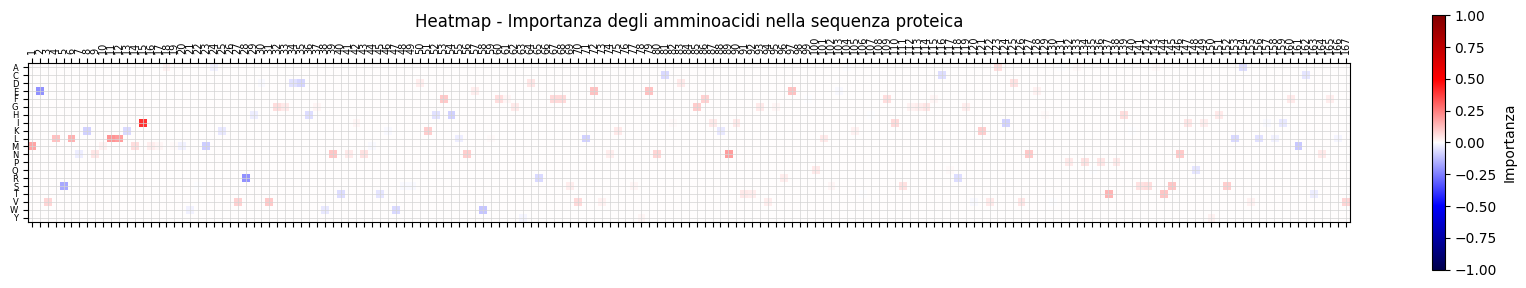

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors



# Rimozione degli elementi 'PAD' dalla sequenza e dagli attributi
generated_text = [aa for aa in generated_text if aa != 'PAD']
attributions_sum = [score for score, aa in zip(attributions_sum, generated_text) if aa != 'PAD']

# Creazione della lista di amminoacidi unici
unique_aminoacids = list(set(generated_text))
unique_aminoacids.sort()

# Creazione della matrice di attributi
attributions_matrix = np.zeros((len(unique_aminoacids), len(generated_text)))
for i, aminoacid in enumerate(generated_text):
    j = unique_aminoacids.index(aminoacid)
    attributions_matrix[j, i] = attributions_sum[i]

# Creazione della figura
fig, ax = plt.subplots(figsize=(17, 13))
 
# Tracciamento della heatmap
#im = ax.imshow(attributions_matrix, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
im = ax.matshow(attributions_matrix, cmap='seismic', vmin=-1, vmax=1)


# Etichettatura degli amminoacidi sull'asse y
ax.set_yticks(np.arange(len(unique_aminoacids)))
ax.set_yticklabels(unique_aminoacids)

# Etichettatura delle posizioni sull'asse x
x_ticks = np.arange(0, len(generated_text), 1)
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.arange(1, len(generated_text)+1)[x_ticks], rotation=90)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=6)


# Aggiunta di una barra dei colori
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.2)

# Personalizzazione della barra dei colori
cbar.set_label('Importanza')
cbar.ax.tick_params(labelsize=10)

# Titolo del grafico
ax.set_title('Heatmap - Importanza degli amminoacidi nella sequenza proteica')

ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)


# Ridimensionamento dei tick sull'asse y
plt.tight_layout()

# Visualizzazione del grafico
plt.show()

<ipython-input-55-56f3e3bcde55>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='aminoacido', y='score', data=df, ci=None, estimator=sum, palette='RdYlBu')


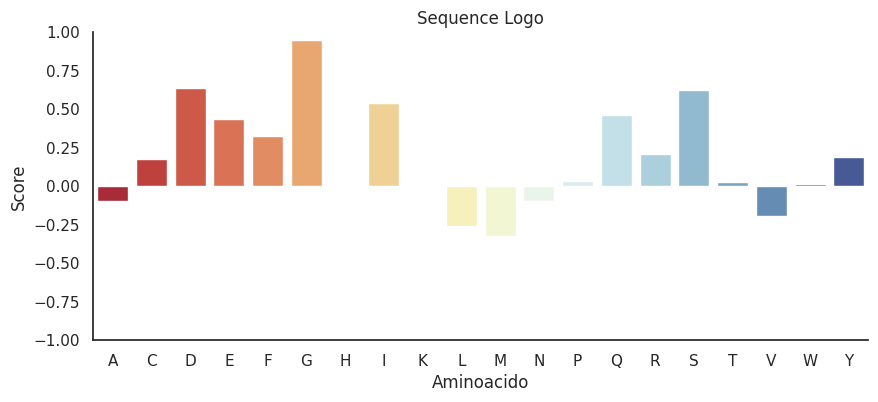

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Rimozione della parte 'PAD' dalla sequenza e dagli attributi
#generated_text = generated_text.rstrip('PAD')
#attributions_sum = attributions_sum[:len(generated_text)]

# Creazione del DataFrame dei dati
data = {'aminoacido': list(generated_text), 'score': attributions_sum}
df = pd.DataFrame(data)

# Calcolo delle frequenze degli amminoacidi
frequencies = df['aminoacido'].value_counts(normalize=True).sort_index()

# Creazione del Sequence Logo
plt.figure(figsize=(10, 4))
sns.set(style="white")
sns.barplot(x='aminoacido', y='score', data=df, ci=None, estimator=sum, palette='RdYlBu')

# Impostazioni dell'asse y
plt.ylim(-1, 1)
plt.ylabel('Score')

# Impostazioni dell'asse x
plt.xlabel('Aminoacido')
plt.xticks(range(len(frequencies)), frequencies.index)

# Titolo del grafico
plt.title('Sequence Logo')

# Rimozione della cornice del grafico
sns.despine()

# Visualizzazione del grafico
plt.show()
